# Fire Detection and Tracking

## 1. Download Dataset

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lituldust","key":"261a3bfabf204e7a7740685aee629cc1"}'}

In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download chrisfilo/firesense

Dataset URL: https://www.kaggle.com/datasets/chrisfilo/firesense
License(s): Attribution 4.0 International (CC BY 4.0)
100% 780M/784M [00:11<00:00, 134MB/s]
100% 784M/784M [00:11<00:00, 70.3MB/s]


In [ ]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Ekstrak file zip dataset
import patoolib

patoolib.extract_archive('/content/firesense.zip')

INFO patool: Extracting /content/firesense.zip ...
INFO:patool:Extracting /content/firesense.zip ...
INFO patool: running /usr/bin/7z x -aou -o./Unpack_nz1vngry -- /content/firesense.zip
INFO:patool:running /usr/bin/7z x -aou -o./Unpack_nz1vngry -- /content/firesense.zip
INFO patool: ... /content/firesense.zip extracted to `firesense' (multiple files in root).
INFO:patool:... /content/firesense.zip extracted to `firesense' (multiple files in root).


'firesense'

In [ ]:
import os
import glob

path = '/content/firesense'
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['smoke', 'fire']


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score # accuracy_score, classification_report, confusion_matrix should already be there
import pickle

In [ ]:
import os
import cv2
from tqdm import tqdm # Make sure tqdm is imported

def extract_frames(video_path, output_folder):
    """Extracts all frames from a video and saves them to an output folder.
    Returns the number of frames saved and the video's FPS.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Error: Could not open video {video_path}")
        return 0, 0.0 # Return a tuple, e.g., (0 frames, 0.0 fps) on error

    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Handle cases where frame_count might be 0 or fps is invalid
    if frame_count <= 0:
        print(f"Warning: Video {os.path.basename(video_path)} reported 0 frames or invalid frame count.")
        video.release()
        return 0, fps if fps > 0 else 0.0 # Return valid fps if available, else 0.0

    if fps <= 0:
        print(f"Warning: Video {os.path.basename(video_path)} reported invalid FPS ({fps:.2f}). Will use a default if needed later.")
        # We still return the reported fps, the calling code can decide on a default.

    print(f"Video: {os.path.basename(video_path)}, FPS: {fps:.2f}, Total frames reported: {frame_count}")

    saved_count = 0
    # Use tqdm for progress bar
    for i in tqdm(range(frame_count), desc=f"Extracting frames from {os.path.basename(video_path)}"):
        success, frame = video.read()
        if not success:
            # This can happen if frame_count is reported incorrectly or video ends prematurely
            print(f"Warning: Could not read frame {i} (expected {frame_count} total). Ending extraction for {video_path}.")
            break

        frame_filename = os.path.join(output_folder, f"frame_{saved_count:05d}.jpg")
        try:
            cv2.imwrite(frame_filename, frame)
            saved_count += 1
        except Exception as e:
            print(f"Error writing frame {frame_filename}: {e}")
            # Optionally, decide if you want to break or continue
            break


    video.release()
    print(f"Successfully extracted {saved_count} frames to {output_folder}")
    return saved_count, fps # Corrected: return both saved_count and fps

def process_videos(input_folder, output_base_folder):
    """Processes all videos in an input folder, extracting frames for each."""
    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    video_files = [f for f in os.listdir(input_folder) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    if not video_files:
        print(f"No video files found in {input_folder}")
        return

    print(f"Found {len(video_files)} videos in {input_folder}.")

    for filename in video_files:
        video_name = os.path.splitext(filename)[0]
        video_path = os.path.join(input_folder, filename)

        # Create a unique folder for each video's frames
        # The folder name for frames will be the video name without extension
        output_folder_for_video = os.path.join(output_base_folder, video_name)

        print(f"\nProcessing video: {filename}")
        extract_frames(video_path, output_folder_for_video)

# 2. Tes Sample Videos

In [ ]:
sample_videos = '/content/firesense/fire/pos/posVideo2.871.avi'
output_frame = '/content/sample_videos/'

extract_frames(sample_videos, output_frame)

Video: posVideo2.871.avi, FPS: 29.97, Total frames: 510


Extracting frames from posVideo2.871.avi: 100%|██████████| 510/510 [00:00<00:00, 618.28it/s]

Successfully extracted 510 frames to /content/sample_videos/


510

## 2.1 Preprocess

In [ ]:
def preprocess_image(image_path, output_path, target_size=(224, 224)):
    try:
        # 1. Read the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image {image_path}. Skipping.")
            return

        # 2. Resize the image
        img_resized = cv2.resize(img, target_size)

        # 3. Blur the image
        img_blurred = cv2.GaussianBlur(img_resized, (5, 5), 0)

        # (Optional) Further preprocessing steps can be added here, e.g.:
        # - Denoising
        # - Contrast enhancement

        # 5. Save the processed image (or you could return it)
        cv2.imwrite(output_path, img_blurred)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

def preprocess_all_frames(input_folder, processed_output_folder, target_size=(224, 224)):
    if not os.path.exists(processed_output_folder):
        os.makedirs(processed_output_folder)
        print(f"Created directory: {processed_output_folder}")

    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No image files found in {input_folder}")
        return

    print(f"Starting preprocessing for {len(image_files)} images in {input_folder}...")
    for filename in image_files:
        image_path = os.path.join(input_folder, filename)
        output_image_path = os.path.join(processed_output_folder, f"processed_{filename}")
        preprocess_image(image_path, output_image_path, target_size)
    print(f"Preprocessing complete. Processed images saved to {processed_output_folder}")

In [ ]:
processed_frame = '/content/processed_frames/'

preprocess_all_frames(output_frame, processed_frame)

Starting preprocessing for 510 images in /content/sample_videos/...
Preprocessing complete. Processed images saved to /content/processed_frames/


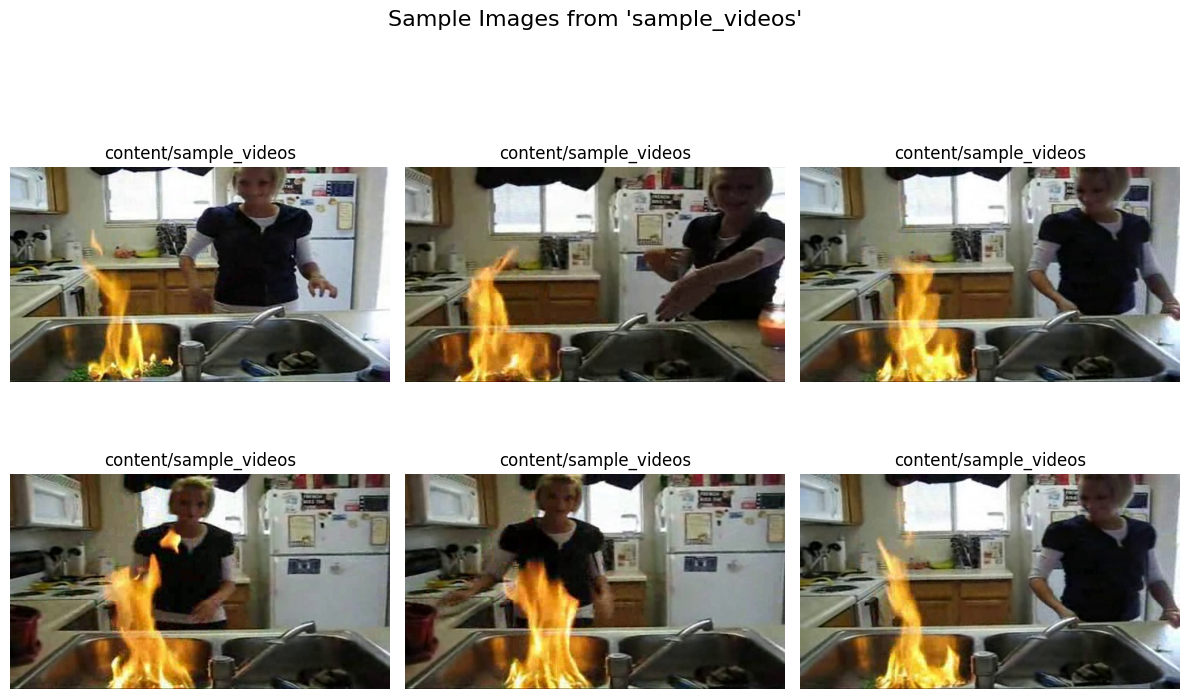

In [ ]:
def display_sample_images(folder_path, num_samples=6, title_prefix="Sample"):
    """Displays a random sample of images from the given folder."""
    sample_paths = []
    # Search for .jpg files in subdirectories of folder_path
    pattern = os.path.join(folder_path, '**', '*.jpg') # '**' for recursive search
    sample_paths.extend(glob.glob(pattern, recursive=True))

    if not sample_paths:
        print("No images found to display. Ensure frames have been extracted and the path is correct.")
        return

    num_samples_to_show = min(num_samples, len(sample_paths))
    if num_samples_to_show == 0:
        print("No images available to sample.")
        return

    selected_image_paths = random.sample(sample_paths, num_samples_to_show)

    cols = 3
    rows = (num_samples_to_show + cols - 1) // cols # Calculate rows needed
    plt.figure(figsize=(cols * 4, rows * 4))
    for i, path in enumerate(selected_image_paths):
        try:
            img = Image.open(path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis('off')

            video_folder_name = os.path.basename(os.path.dirname(path))
            path_parts = path.split(os.sep)

            image_parent_dir = os.path.dirname(path)
            video_folder_name_title = os.path.basename(image_parent_dir)
            class_label_title = os.path.basename(os.path.dirname(image_parent_dir))

            plt.title(f"{class_label_title}/{video_folder_name_title}")
        except Exception as e:
            print(f"Error loading image {path}: {e}")

    # Use the basename of the input folder_path for the suptitle
    main_folder_name = os.path.basename(folder_path.rstrip(os.sep)) # rstrip to handle trailing slash
    plt.suptitle(f"{title_prefix} Images from '{main_folder_name}'", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

display_sample_images(output_frame, num_samples=6)

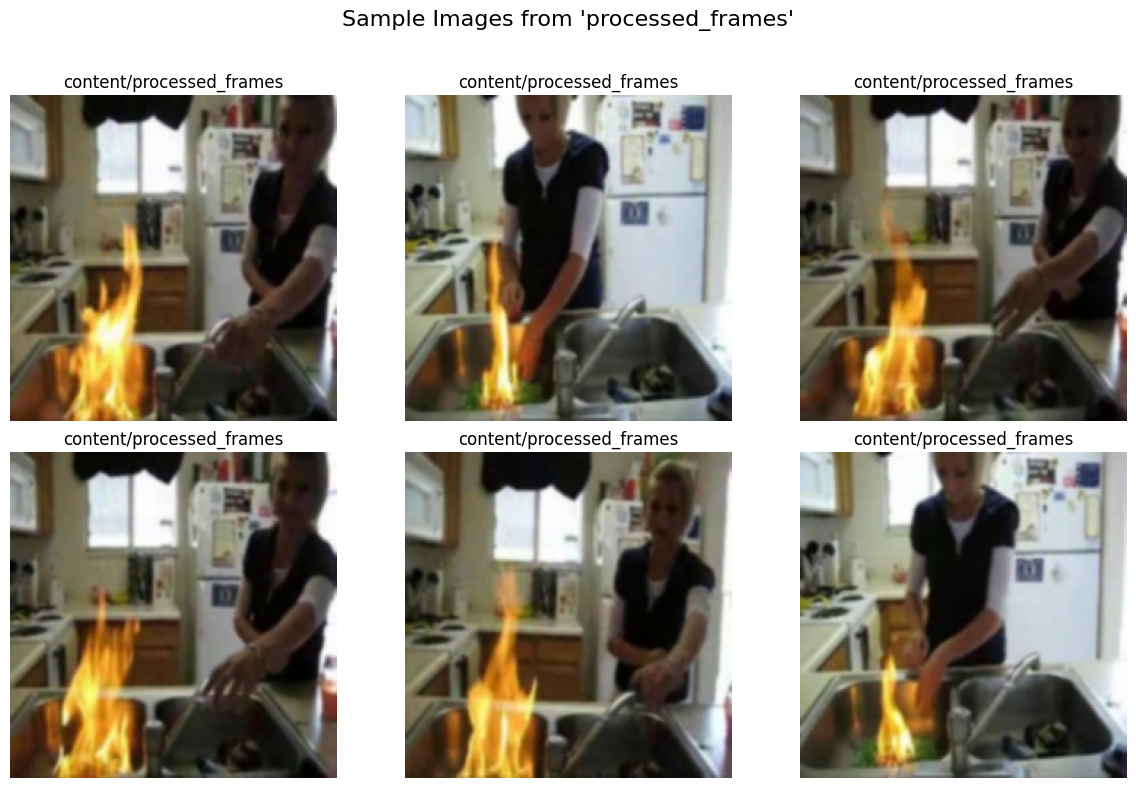

In [ ]:
display_sample_images(processed_frame, num_samples=6)

# 2.2 Feature Extraction

In [ ]:
# Sample image to display
sample_img_paths_list = glob.glob(os.path.join(processed_frame, '*.jpg'))

if sample_img_paths_list:
    image_path_to_process = sample_img_paths_list[0] # Using the first image
    print(f"Loading sample image: {image_path_to_process}")

Loading sample image: /content/processed_frames/processed_frame_00414.jpg


### 2.2.1 Color Features

In [ ]:
def extract_ycrcb_features(frame):
    ycrcb = cv2.cvtColor(frame, cv2.COLOR_RGB2YCrCb)
    features = []
    for channel in cv2.split(ycrcb):
        features.append(np.mean(channel))
        features.append(np.std(channel))
    return np.array(features)

def extract_hsv_features(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    features = []
    for channel in cv2.split(hsv):
        features.append(np.mean(channel))
        features.append(np.std(channel))
    return np.array(features)

def extract_hsv_hist(frame):
  hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
  features = []
  for channel in cv2.split(hsv):
    hist = cv2.calcHist([channel], [0], None, [32], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    features.extend(hist)
  return np.array(features)

def extract_ycrcb_hist(frame):
  YCrCb = cv2.cvtColor(frame, cv2.COLOR_RGB2YCrCb)
  features = []
  for channel in cv2.split(YCrCb):
    hist = cv2.calcHist([channel], [0], None, [32], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    features.extend(hist)
  return np.array(features)

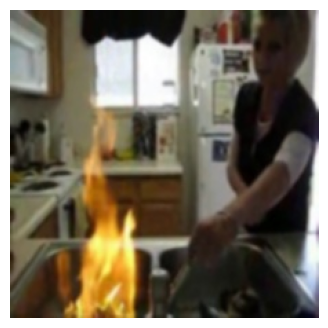

In [ ]:
sample1 = cv2.imread(image_path_to_process)

rgb_image = cv2.cvtColor(sample1, cv2.COLOR_BGR2RGB)

ycrcb_feat = extract_ycrcb_features(rgb_image)
hsv_feat = extract_hsv_features(rgb_image)
ycrcb_hist = extract_ycrcb_hist(rgb_image)
hsv_hist = extract_hsv_hist(rgb_image)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

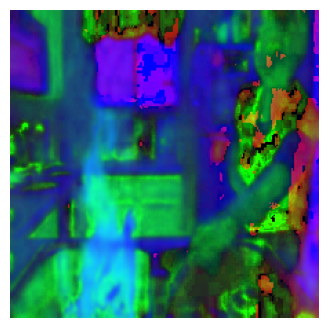

In [ ]:
hsv_img = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(hsv_img)
plt.axis('off')
plt.show()

In [ ]:
hist_h = cv2.calcHist([hsv_img], [0], None, [16], [0, 180])
hist_s = cv2.calcHist([hsv_img], [1], None, [16], [0, 256])
hist_v = cv2.calcHist([hsv_img], [2], None, [16], [0, 256])
cv2.normalize(hist_h, hist_h, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
cv2.normalize(hist_s, hist_s, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
cv2.normalize(hist_v, hist_v, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

array([[7.09213495e-01],
       [6.48764074e-01],
       [9.88314629e-01],
       [8.19999993e-01],
       [1.00000000e+00],
       [6.14606738e-01],
       [5.48539340e-01],
       [8.54157329e-01],
       [4.64943826e-01],
       [4.60898876e-01],
       [2.78876394e-01],
       [1.21797755e-01],
       [1.12359598e-02],
       [4.74392436e-09],
       [1.16179779e-01],
       [5.24269640e-01]], dtype=float32)

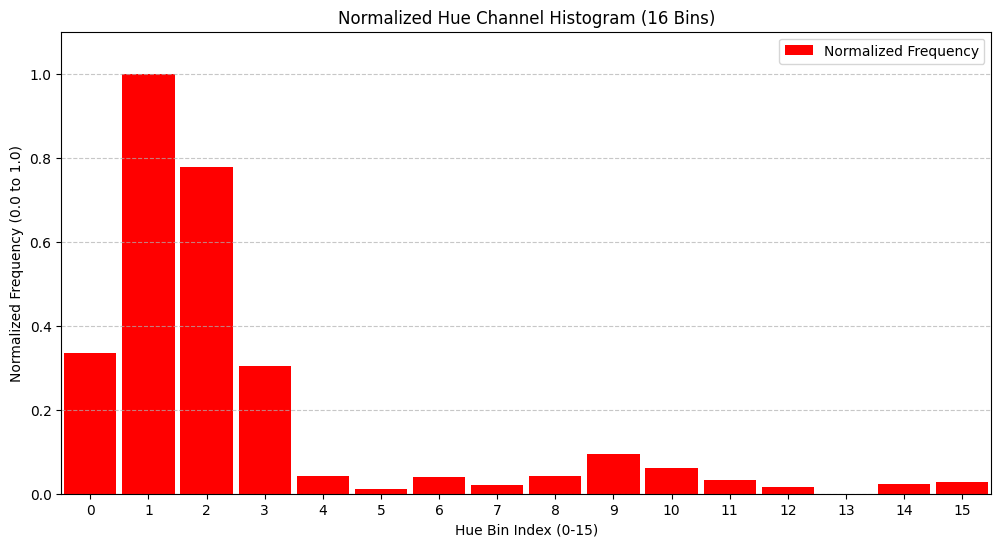

In [ ]:
# --- Visualize the histogram hist_h ---
histogram_values = hist_h.flatten()
number_of_bins = len(histogram_values)

# Create an array for the x-axis positions of the bars (0, 1, 2, ..., 15)
bin_indices = np.arange(number_of_bins)

# Create the plot
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
plt.bar(bin_indices, histogram_values, color='red', width=0.9, label='Normalized Frequency')
plt.xlabel("Hue Bin Index (0-15)")
plt.ylabel("Normalized Frequency (0.0 to 1.0)")
plt.title("Normalized Hue Channel Histogram (16 Bins)")
plt.xticks(bin_indices)
plt.xlim([-0.5, number_of_bins - 0.5]) # Adds a little space at the ends
plt.ylim([0, 1.1]) # Since normalized values are 0-1, extend y-limit slightly
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

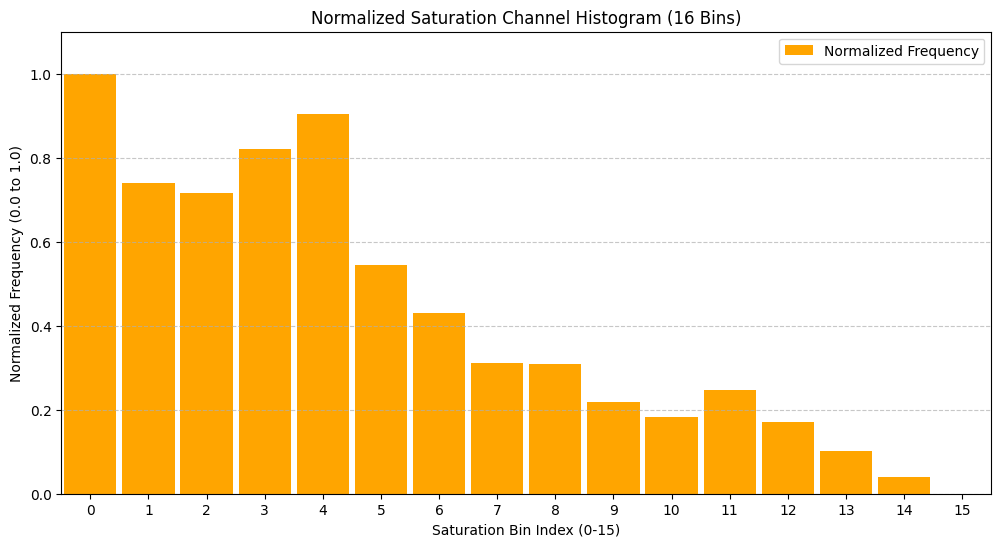

In [ ]:
# --- Visualize the histogram hist_s ---
histogram_values = hist_s.flatten()
number_of_bins = len(histogram_values)

# Create an array for the x-axis positions of the bars (0, 1, 2, ..., 15)
bin_indices = np.arange(number_of_bins)

# Create the plot
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
plt.bar(bin_indices, histogram_values, color='orange', width=0.9, label='Normalized Frequency')
plt.xlabel("Saturation Bin Index (0-15)")
plt.ylabel("Normalized Frequency (0.0 to 1.0)")
plt.title("Normalized Saturation Channel Histogram (16 Bins)")
plt.xticks(bin_indices)
plt.xlim([-0.5, number_of_bins - 0.5]) # Adds a little space at the ends
plt.ylim([0, 1.1]) # Since normalized values are 0-1, extend y-limit slightly
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

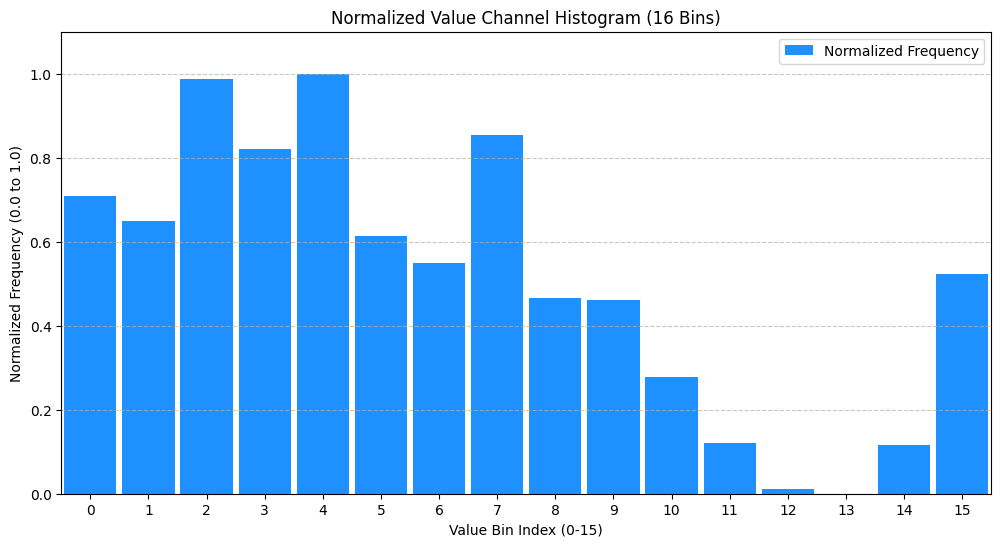

In [ ]:
# --- Visualize the histogram hist_v ---
histogram_values = hist_v.flatten()
number_of_bins = len(histogram_values)

# Create an array for the x-axis positions of the bars (0, 1, 2, ..., 15)
bin_indices = np.arange(number_of_bins)

# Create the plot
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
plt.bar(bin_indices, histogram_values, color='dodgerblue', width=0.9, label='Normalized Frequency')
plt.xlabel("Value Bin Index (0-15)")
plt.ylabel("Normalized Frequency (0.0 to 1.0)")
plt.title("Normalized Value Channel Histogram (16 Bins)")
plt.xticks(bin_indices)
plt.xlim([-0.5, number_of_bins - 0.5]) # Adds a little space at the ends
plt.ylim([0, 1.1]) # Since normalized values are 0-1, extend y-limit slightly
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

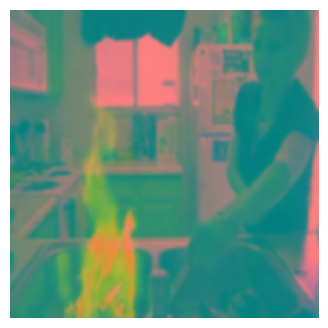

In [ ]:
ycrcb_img = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YCrCb)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(ycrcb_img)
plt.axis('off')
plt.show()

In [ ]:
hist_y = cv2.calcHist([ycrcb_img], [0], None, [16], [0, 256])
hist_cr = cv2.calcHist([ycrcb_img], [1], None, [16], [0, 256])
hist_cb = cv2.calcHist([ycrcb_img], [2], None, [16], [0, 256])
cv2.normalize(hist_y, hist_y, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
cv2.normalize(hist_cr, hist_cr, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
cv2.normalize(hist_cb, hist_cb, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

array([[0.0000000e+00],
       [0.0000000e+00],
       [2.9445540e-05],
       [4.4668883e-02],
       [3.7307501e-02],
       [3.6512472e-02],
       [1.3070875e-01],
       [1.0000000e+00],
       [2.2570007e-01],
       [2.5323164e-03],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

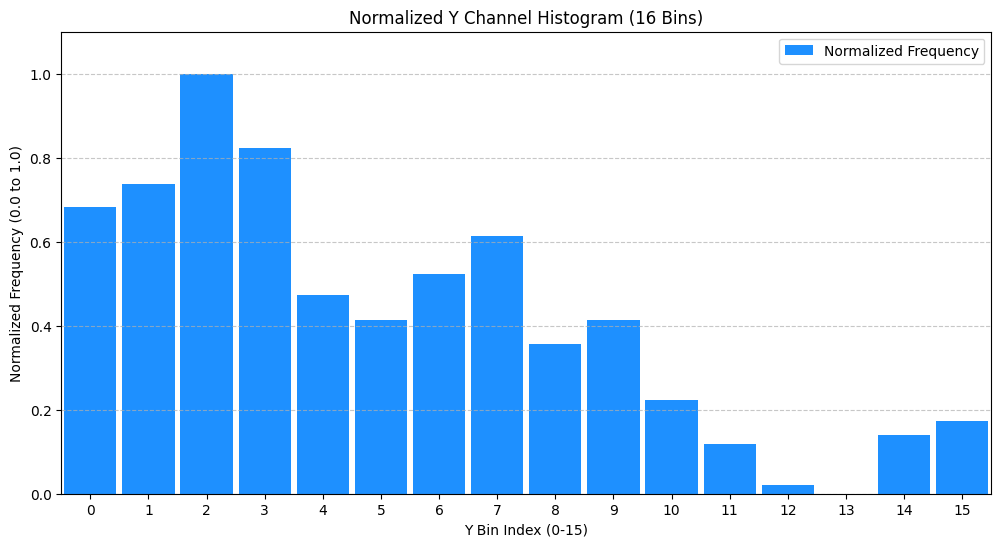

In [ ]:
# --- Visualize the histogram hist_y ---
histogram_values = hist_y.flatten()
number_of_bins = len(histogram_values)

# Create an array for the x-axis positions of the bars (0, 1, 2, ..., 15)
bin_indices = np.arange(number_of_bins)

# Create the plot
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
plt.bar(bin_indices, histogram_values, color='dodgerblue', width=0.9, label='Normalized Frequency')
plt.xlabel("Y Bin Index (0-15)")
plt.ylabel("Normalized Frequency (0.0 to 1.0)")
plt.title("Normalized Y Channel Histogram (16 Bins)")
plt.xticks(bin_indices)
plt.xlim([-0.5, number_of_bins - 0.5]) # Adds a little space at the ends
plt.ylim([0, 1.1]) # Since normalized values are 0-1, extend y-limit slightly
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

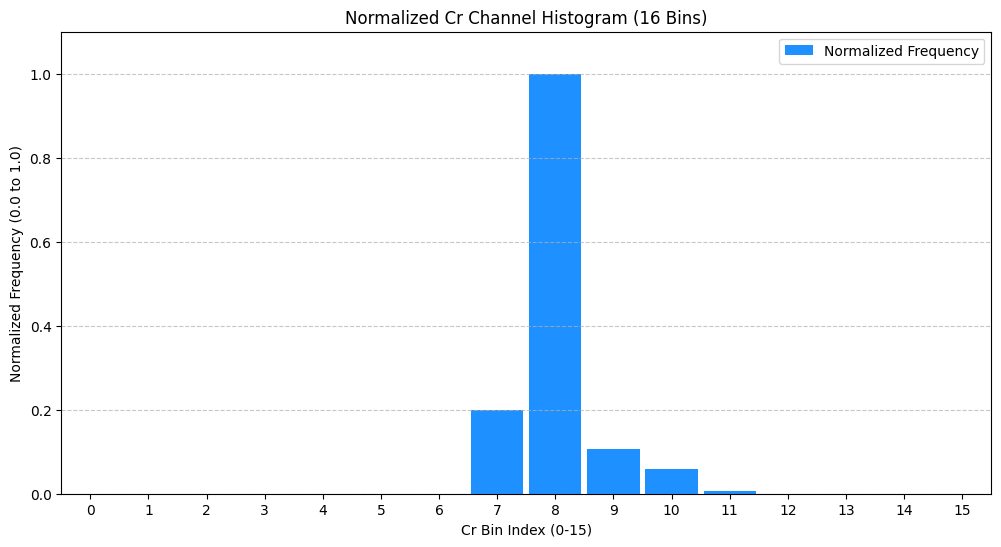

In [ ]:
# --- Visualize the histogram hist_cr ---
histogram_values = hist_cr.flatten()
number_of_bins = len(histogram_values)

# Create an array for the x-axis positions of the bars (0, 1, 2, ..., 15)
bin_indices = np.arange(number_of_bins)

# Create the plot
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
plt.bar(bin_indices, histogram_values, color='dodgerblue', width=0.9, label='Normalized Frequency')
plt.xlabel("Cr Bin Index (0-15)")
plt.ylabel("Normalized Frequency (0.0 to 1.0)")
plt.title("Normalized Cr Channel Histogram (16 Bins)")
plt.xticks(bin_indices)
plt.xlim([-0.5, number_of_bins - 0.5]) # Adds a little space at the ends
plt.ylim([0, 1.1]) # Since normalized values are 0-1, extend y-limit slightly
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

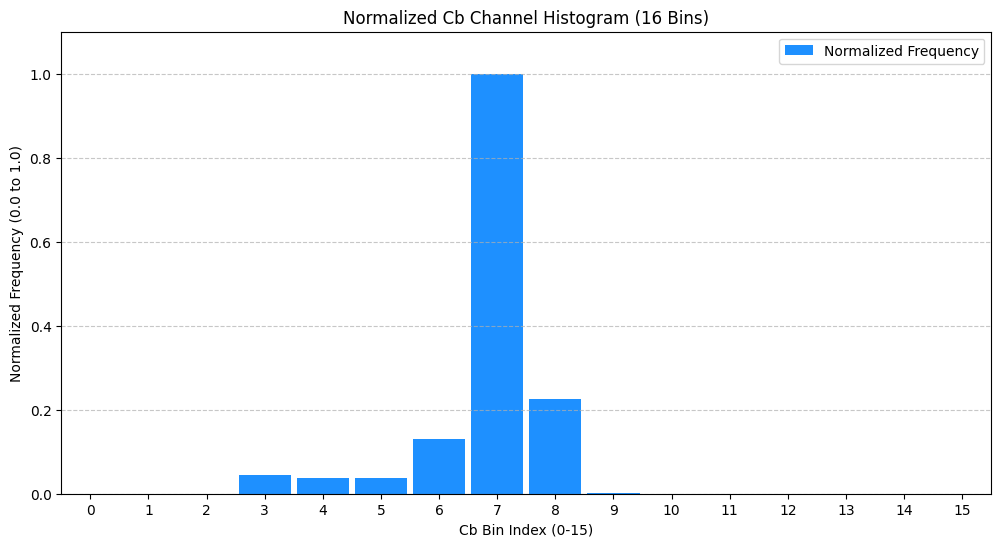

In [ ]:
# --- Visualize the histogram hist_cb ---
histogram_values = hist_cb.flatten()
number_of_bins = len(histogram_values)

# Create an array for the x-axis positions of the bars (0, 1, 2, ..., 15)
bin_indices = np.arange(number_of_bins)

# Create the plot
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
plt.bar(bin_indices, histogram_values, color='dodgerblue', width=0.9, label='Normalized Frequency')
plt.xlabel("Cb Bin Index (0-15)")
plt.ylabel("Normalized Frequency (0.0 to 1.0)")
plt.title("Normalized Cb Channel Histogram (16 Bins)")
plt.xticks(bin_indices)
plt.xlim([-0.5, number_of_bins - 0.5]) # Adds a little space at the ends
plt.ylim([0, 1.1]) # Since normalized values are 0-1, extend y-limit slightly
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

YCrCb Features: [ 91.53134965  65.2019391  134.41832749  10.24044021 117.08274872
  15.75179828]
HSV Features: [ 36.25075733  36.71145389  86.78569436  64.51344345 101.9502551
  68.7156332 ]


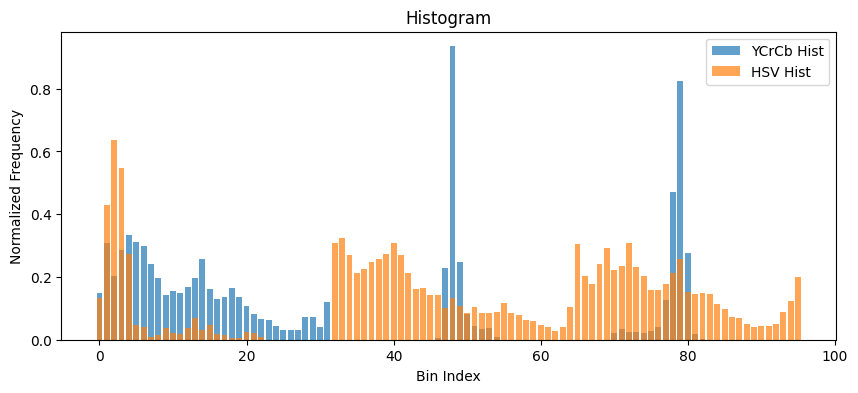

In [ ]:
# Menampilkan perbandingan visualisasi HSV dan YCrCb
print("YCrCb Features:", ycrcb_feat)
print("HSV Features:", hsv_feat)

plt.figure(figsize=(10, 4))
plt.bar(range(len(ycrcb_hist)), ycrcb_hist, alpha=0.7, label='YCrCb Hist')
plt.bar(range(len(hsv_hist)), hsv_hist, alpha=0.7, label='HSV Hist')
plt.title('Histogram')
plt.xlabel('Bin Index')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.show()

### 2.2.2 Texture Features

#### Local Binary Pattern (LBP)

In [ ]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, P=8, R=1):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  lbp = local_binary_pattern(gray, P, R, method="uniform")

  (hist, _) = np.histogram(lbp.ravel(),
                           bins=np.arange(0, P + 3),
                           range=(0, P + 2))
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-6)

  return hist

Text(0, 0.5, 'Normalized Frequency')

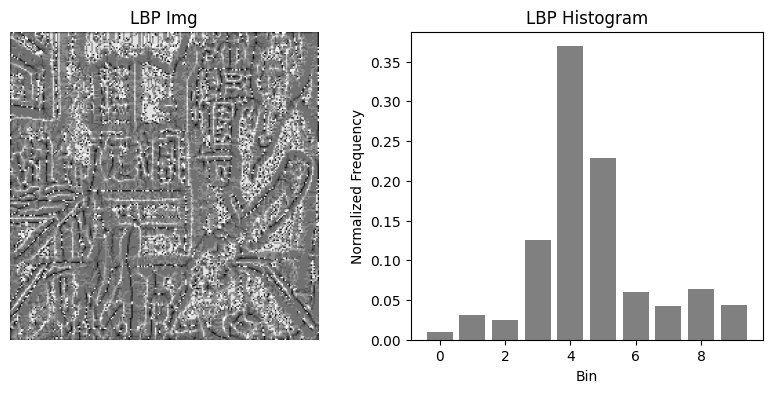

In [ ]:
sample_hist_lbp = extract_lbp_features(sample1)
sample_lbp = local_binary_pattern(cv2.cvtColor(sample1, cv2.COLOR_RGB2GRAY), 8, 1, method="uniform")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_lbp, cmap='gray')
plt.title('LBP Img')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(range(len(sample_hist_lbp)), sample_hist_lbp, color='gray')
plt.title('LBP Histogram')
plt.xlabel('Bin')
plt.ylabel('Normalized Frequency')

#### Gray Level Co-occurence Matrix (GLCM)

In [ ]:
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(image, distances=[5], angles=[0]):
  features = []
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  glcm = graycomatrix(gray, distances=distances, angles=angles,
                      levels=256, symmetric=True, normed=True)

  for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
    feature = graycoprops(glcm, prop)[0, 0]
    features.append(feature)
  features /= sum(features)
  return np.array(features)

contrast: 0.9835302787314558
dissimilarity: 0.015828058834174066
homogeneity: 7.18097215794263e-05
energy: 8.44252495037635e-06
correlation: 0.0005613058816949623
ASM: 1.0430614549723308e-07


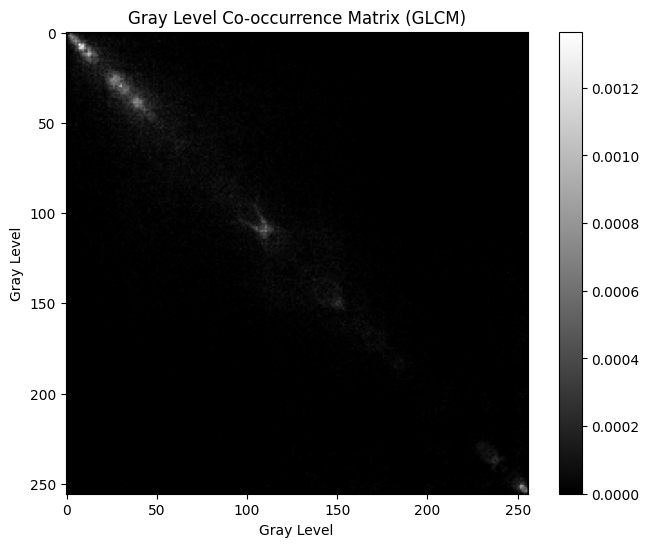

In [ ]:
# Compute GLCM for visualization
sample_glcm = extract_glcm_features(sample1)
glcm = graycomatrix(cv2.cvtColor(sample1, cv2.COLOR_RGB2GRAY), distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

for i, prop in enumerate(['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']):
  print(f"{prop}: {sample_glcm[i]}")

# Visualize the GLCM
plt.figure(figsize=(8, 6))
plt.imshow(glcm[:, :, 0, 0], cmap='gray')
plt.colorbar()
plt.title("Gray Level Co-occurrence Matrix (GLCM)")
plt.xlabel("Gray Level")
plt.ylabel("Gray Level")
plt.show()

#### 2.2.3 Motion Based

In [ ]:
def extract_hof(prev_frame, curr_frame, nbins=8):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray,
                                        None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)

    bin_edges = np.linspace(0, 360, nbins + 1)
    hof_hist, _ = np.histogram(ang, bins=bin_edges, weights=mag, density=True)

    return hof_hist, flow

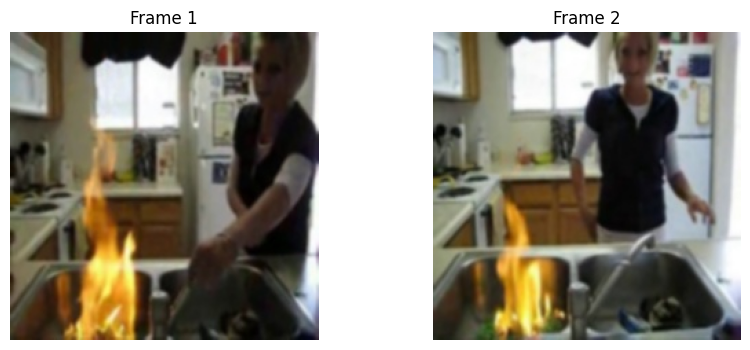

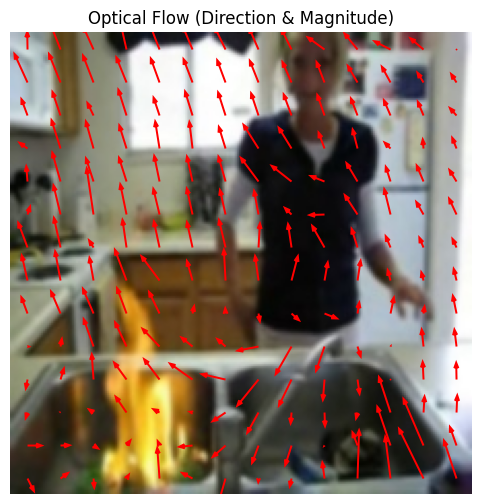

In [ ]:
def show_optical_flow_arrows(prev_frame_rgb, curr_frame_rgb, step=16): # Renamed params for clarity
    # Note: The grayscale conversion here is redundant if extract_hof is called first
    # and only flow is needed. However, if it's for independent processing or clarity, it's fine.
    # prev_gray = cv2.cvtColor(prev_frame_rgb, cv2.COLOR_RGB2GRAY)
    # curr_gray = cv2.cvtColor(curr_frame_rgb, cv2.COLOR_RGB2GRAY)

    # We need the flow; extract_hof calculates it.
    # The prev_gray and curr_gray for visualization of arrows should match those used for flow.
    _, flow = extract_hof(prev_frame_rgb, curr_frame_rgb) # Re-use your HOF function

    # Get dimensions from one of the original frames (or its gray equivalent)
    # Using shape from curr_frame_rgb before potential modification
    h, w = curr_frame_rgb.shape[:2] # Use RGB frame shape, gray conversion is internal to HOF

    y, x = np.mgrid[step//2:h:step, step//2:w:step].astype(int)

    # Ensure y, x are within bounds of flow map
    y = np.clip(y, 0, flow.shape[0]-1)
    x = np.clip(x, 0, flow.shape[1]-1)

    fx, fy = flow[y, x].T

    plt.figure(figsize=(10, 6))
    plt.imshow(curr_frame_rgb) # Display the original color current frame
    plt.quiver(x, y, fx, fy, color='red', angles='xy', scale_units='xy', scale=1, headwidth=3, headlength=4)
    plt.title('Optical Flow (Direction & Magnitude)')
    plt.axis('off')
    plt.show()

# 1. Load the first image from its path
path1 = sample_img_paths_list[0]
frame1_bgr = cv2.imread(path1)
if frame1_bgr is None:
    raise FileNotFoundError(f"Error: Could not load image from path: {path1}")
# Convert from BGR (OpenCV default) to RGB
frame1_rgb = cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2RGB)

# 2. Load the second image from its path
path2 = sample_img_paths_list[1]
frame2_bgr = cv2.imread(path2)
if frame2_bgr is None:
    raise FileNotFoundError(f"Error: Could not load image from path: {path2}")
# Convert from BGR to RGB
frame2_rgb = cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2RGB)


# 3. Now use the loaded RGB image arrays for display
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(frame1_rgb) # Pass the loaded image data
plt.title('Frame 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(frame2_rgb) # Pass the loaded image data
plt.title('Frame 2')
plt.axis('off')
plt.show()

# 4. Pass the loaded RGB image arrays to your optical flow function
show_optical_flow_arrows(frame1_rgb, frame2_rgb)

#### Redeclare some method to save the features

In [ ]:
# --- Feature Extraction Functions (from your provided code) ---
def extract_ycrcb_features(frame_rgb_np): # Expects NumPy RGB
    ycrcb = cv2.cvtColor(frame_rgb_np, cv2.COLOR_RGB2YCrCb)
    features = []
    for channel in cv2.split(ycrcb):
        features.append(np.mean(channel))
        features.append(np.std(channel))
    return np.array(features)

def extract_hsv_features(frame_rgb_np): # Expects NumPy RGB
    hsv = cv2.cvtColor(frame_rgb_np, cv2.COLOR_RGB2HSV)
    features = []
    for channel in cv2.split(hsv):
        features.append(np.mean(channel))
        features.append(np.std(channel))
    return np.array(features)

def extract_lbp_features(image_rgb_np, P=8, R=1): # Expects NumPy RGB
    gray = cv2.cvtColor(image_rgb_np, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P, R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, P + 3),
                             range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7) # Epsilon for stability
    return hist

# Modified extract_glcm_features for robustness
def extract_glcm_features(image_rgb_np, distances=[5], angles=[0]): # Expects NumPy RGB
    feature_values_list = []
    gray = cv2.cvtColor(image_rgb_np, cv2.COLOR_RGB2GRAY)

    glcm = graycomatrix(gray, distances=distances, angles=angles,
                        levels=256, symmetric=True, normed=True)

    props_to_extract = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in props_to_extract:
        val = graycoprops(glcm, prop)[0, 0]
        feature_values_list.append(val)

    feature_values_array = np.array(feature_values_list, dtype=np.float32)

    sum_of_features = np.sum(feature_values_array)
    if sum_of_features > 1e-7: # Add epsilon for stability
        normalized_features = feature_values_array / sum_of_features
    else:
        normalized_features = feature_values_array

    return normalized_features

def extract_hof(prev_frame_rgb_np, curr_frame_rgb_np, nbins=8): # Expects NumPy RGB
    prev_gray = cv2.cvtColor(prev_frame_rgb_np, cv2.COLOR_RGB2GRAY)
    curr_gray = cv2.cvtColor(curr_frame_rgb_np, cv2.COLOR_RGB2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray,
                                        None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)

    bin_edges = np.linspace(0, 360, nbins + 1)
    hof_hist, _ = np.histogram(ang.ravel(), bins=bin_edges, weights=mag.ravel(), density=True)

    hof_hist = np.nan_to_num(hof_hist) # Handle potential NaN/inf

    return hof_hist, flow # Returning flow might be useful for visualization

# --- Updated extract_all_features function ---
def extract_all_features(current_pil_image, previous_pil_image,
                         img_size=(128, 128),
                         P_lbp=8, R_lbp=1,
                         glcm_distances=[5], glcm_angles=[0],
                         hof_nbins=8):
    """
    Resizes PIL images, converts to RGB NumPy arrays,
    then extracts and concatenates HSV, YCrCb, LBP, GLCM, and HOF features.
    """
    # Resize and convert current image
    current_img_resized_pil = current_pil_image.resize(img_size)
    current_img_np_rgb = np.array(current_img_resized_pil)

    # Static features from current frame
    hsv_mean_std_features = extract_hsv_features(current_img_np_rgb)
    ycrcb_mean_std_features = extract_ycrcb_features(current_img_np_rgb)
    lbp_features_val = extract_lbp_features(current_img_np_rgb, P=P_lbp, R=R_lbp)
    glcm_features_val = extract_glcm_features(current_img_np_rgb, distances=glcm_distances, angles=glcm_angles)

    # Motion features (HOF) using previous and current frames
    if previous_pil_image is not None:
        previous_img_resized_pil = previous_pil_image.resize(img_size)
        previous_img_np_rgb = np.array(previous_img_resized_pil)
        hof_features_val, _ = extract_hof(previous_img_np_rgb, current_img_np_rgb, nbins=hof_nbins)
    else:
        # Handle first frame: HOF features are zero or based on a default
        hof_features_val = np.zeros(hof_nbins)
        print("Note: First frame, HOF features set to zeros.")

    all_features_list = [
        hsv_mean_std_features.flatten(),
        ycrcb_mean_std_features.flatten(),
        lbp_features_val.flatten(),
        glcm_features_val.flatten(),
        hof_features_val.flatten()
    ]
    final_features_vector = np.concatenate(all_features_list)
    return final_features_vector

# 3. Sample Tracking Video

In [ ]:
def detect_and_visualize_fire_roi(image_path, output_visualization_path=None):
    # 1. Load the frame
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: Could not load image {image_path}")
        return

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define fire color ranges in HSV

    # Range for red (lower hue values)
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])

    # Range for red (higher hue values, wrapping around)
    lower_red2 = np.array([165, 100, 100])
    upper_red2 = np.array([179, 255, 255])

    # Range for orange/yellow
    lower_orange_yellow = np.array([11, 100, 150]) # Starting from orange, V higher for brightness
    upper_orange_yellow = np.array([35, 255, 255])   # Up to yellow

    # 3. Create masks based on the color ranges
    mask_red1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
    mask_orange_yellow = cv2.inRange(img_hsv, lower_orange_yellow, upper_orange_yellow)

    # Combine the masks
    fire_mask = cv2.bitwise_or(mask_red1, mask_red2)
    fire_mask = cv2.bitwise_or(fire_mask, mask_orange_yellow)

    # 4. Morphological operations to refine the mask (remove noise and close gaps)
    kernel_open = np.ones((3, 3), np.uint8)
    kernel_close = np.ones((7, 7), np.uint8)

    fire_mask_morphed = cv2.morphologyEx(fire_mask, cv2.MORPH_OPEN, kernel_open, iterations=1)
    fire_mask_morphed = cv2.morphologyEx(fire_mask_morphed, cv2.MORPH_CLOSE, kernel_close, iterations=2)
    fire_mask_morphed = cv2.dilate(fire_mask_morphed, kernel_close, iterations=1)

    # 5. Find contours in the refined mask
    contours, _ = cv2.findContours(fire_mask_morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_with_roi = img_rgb.copy()
    fire_detected_in_image = False

    if contours:
        min_contour_area = 150  # Adjust based on image size and expected fire size
        significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

        if significant_contours:
            fire_detected_in_image = True
            for contour in significant_contours:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(img_with_roi, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(img_with_roi, "Fire", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            print(f"🔥 Fire ROI detected and localized in {os.path.basename(image_path)}.")
        else:
            print(f"No significant fire ROI found after contour filtering in {os.path.basename(image_path)}.")
    else:
        print(f"No initial fire ROI (contours) found in {os.path.basename(image_path)}.")

    # 6. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(img_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(fire_mask_morphed, cmap='gray')
    axes[1].set_title("Segmented Fire Mask")
    axes[1].axis('off')

    axes[2].imshow(img_with_roi)
    if fire_detected_in_image:
        axes[2].set_title("Fire Detected & Localized")
    else:
        axes[2].set_title("No Fire Detected")
    axes[2].axis('off')

    plt.suptitle(f"Fire Detection Analysis: {os.path.basename(image_path)}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for suptitle

    if output_visualization_path:
        try:
            plt.savefig(output_visualization_path)
            print(f"💾 Visualization saved to {output_visualization_path}")
        except Exception as e:
            print(f"Error saving visualization: {e}")
    plt.show()

🔥 Fire ROI detected and localized in processed_frame_00414.jpg.


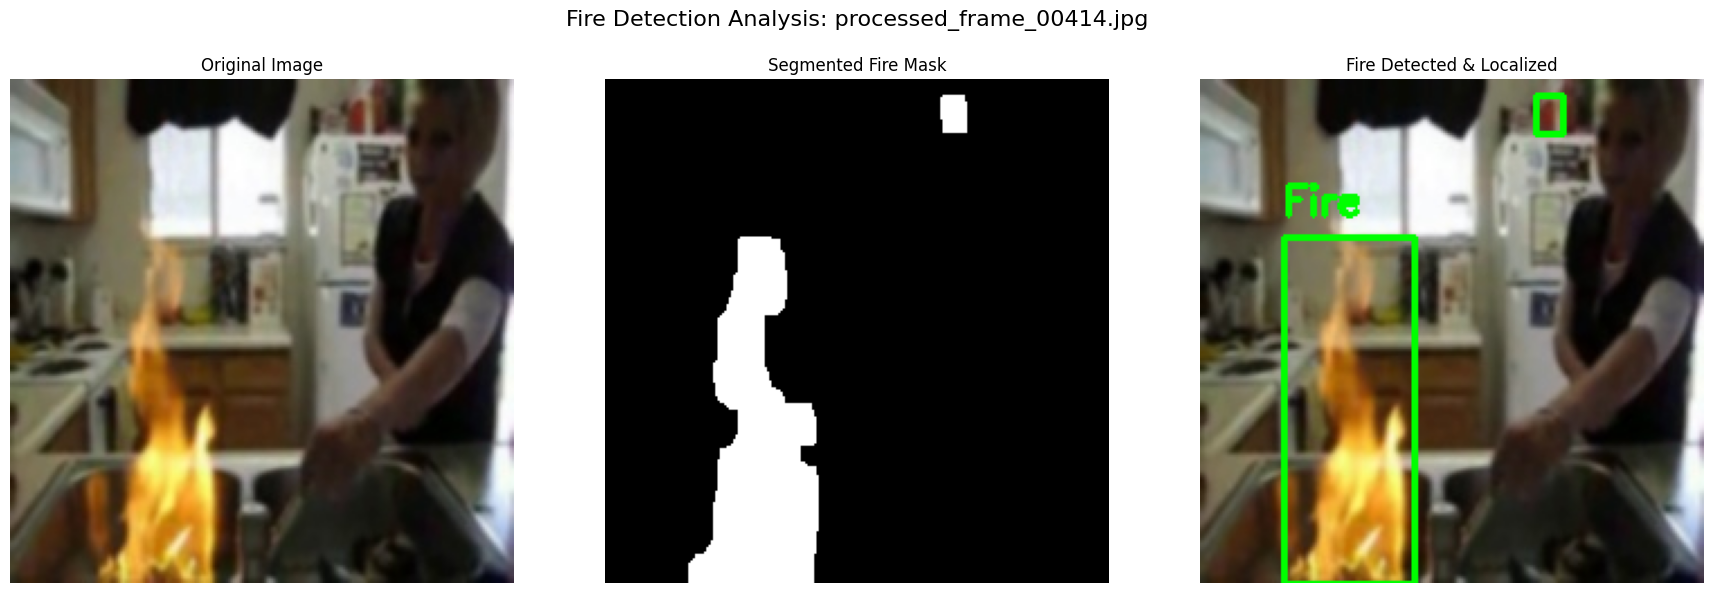

In [ ]:
detect_and_visualize_fire_roi(sample_img_paths_list[0])

In [ ]:
def detect_fire_roi_for_tracking(image_path, min_contour_area=150):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: Could not load image {image_path} for ROI detection.")
        return None, []

    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # HSV color ranges for fire
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([165, 100, 100])
    upper_red2 = np.array([179, 255, 255])
    lower_orange_yellow = np.array([11, 100, 150])
    upper_orange_yellow = np.array([35, 255, 255])

    mask_red1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
    mask_orange_yellow = cv2.inRange(img_hsv, lower_orange_yellow, upper_orange_yellow)

    fire_mask = cv2.bitwise_or(mask_red1, mask_red2)
    fire_mask = cv2.bitwise_or(fire_mask, mask_orange_yellow)

    kernel_open = np.ones((3, 3), np.uint8)
    kernel_close = np.ones((7, 7), np.uint8)
    fire_mask_morphed = cv2.morphologyEx(fire_mask, cv2.MORPH_OPEN, kernel_open, iterations=1)
    fire_mask_morphed = cv2.morphologyEx(fire_mask_morphed, cv2.MORPH_CLOSE, kernel_close, iterations=2)

    contours, _ = cv2.findContours(fire_mask_morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_rois = []
    if contours:
        significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
        if significant_contours:
            for contour in significant_contours:
                x, y, w, h = cv2.boundingRect(contour)
                detected_rois.append((x, y, w, h))
            print(f"🔥 Fire ROI detected for tracking in {os.path.basename(image_path)}: {len(detected_rois)} regions.")
        else:
            print(f"No significant fire ROI found after contour filtering in {os.path.basename(image_path)}.")
    else:
        print(f"No initial fire ROI (contours) found in {os.path.basename(image_path)}.")

    return img_bgr, detected_rois

In [ ]:
def get_frame_with_fire_roi(img_bgr):
    # Handling error if error reading the frame
    if img_bgr is None:
        print("Error: Input image to get_frame_with_fire_roi is None.")
        return None, False

    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # HSV color ranges for fire detection (same as in detect_and_visualize_fire_roi)
    lower_red1 = np.array([0, 130, 140])       # Increased S_min, V_min
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 130, 140])     # Increased S_min, V_min
    upper_red2 = np.array([180, 255, 255])
    lower_yellow_orange = np.array([11, 130, 140]) # Increased S_min, V_min
    upper_yellow_orange = np.array([35, 255, 255])

    mask_red1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
    mask_orange_yellow = cv2.inRange(img_hsv, lower_orange_yellow, upper_orange_yellow)

    fire_mask = cv2.bitwise_or(mask_red1, mask_red2)
    fire_mask = cv2.bitwise_or(fire_mask, mask_orange_yellow)

    kernel_open = np.ones((3, 3), np.uint8)
    kernel_close = np.ones((7, 7), np.uint8)

    fire_mask_morphed = cv2.morphologyEx(fire_mask, cv2.MORPH_OPEN, kernel_open, iterations=1)
    fire_mask_morphed = cv2.morphologyEx(fire_mask_morphed, cv2.MORPH_CLOSE, kernel_close, iterations=2)

    contours, _ = cv2.findContours(fire_mask_morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_with_roi_bgr = img_bgr.copy()
    fire_detected_in_frame = False

    if contours:
        min_contour_area = 150
        significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

        if significant_contours:
            fire_detected_in_frame = True
            for contour in significant_contours:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(img_with_roi_bgr, (x, y), (x + w, y + h), (255, 255, 0), 2)
                cv2.putText(img_with_roi_bgr, "Fire", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    return img_with_roi_bgr, fire_detected_in_frame

# Save to video
def track_fire_and_extract_features_to_video(processed_frames_folder, output_video_path, fps):
    # Assuming frame filenames are like 'processed_frame_00000.jpg', 'processed_frame_00001.jpg', etc.
    # Adjust the glob pattern if your filenames are different.
    frame_paths = sorted(glob.glob(os.path.join(processed_frames_folder, 'processed_frame_*.jpg')))

    if not frame_paths:
        print(f"No processed frames found in {processed_frames_folder} matching pattern 'processed_frame_*.jpg'. Cannot create video.")
        return

    # Determine frame size from the first frame
    try:
        first_frame_pil = Image.open(frame_paths[0])
        width, height = first_frame_pil.size
        frame_size = (width, height) # This is the size of frames read from processed_frames_folder
    except Exception as e:
        print(f"Error: Could not read the first frame {frame_paths[0]} to determine size: {e}")
        return

    # Initialize VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'XVID') # For .avi
    out_video = cv2.VideoWriter(output_video_path, fourcc, float(fps), frame_size)

    print(f"Starting video creation: {output_video_path} with FPS: {fps:.2f} and frame size: {frame_size}")

    previous_pil_image = None # Initialize previous image for HOF

    for i, frame_path in enumerate(tqdm(frame_paths, desc="Tracking fire and creating video")):
        try:
            current_pil_image = Image.open(frame_path).convert('RGB')

            # Convert current PIL image to BGR NumPy for OpenCV operations (like drawing ROI)
            current_img_bgr_np = cv2.cvtColor(np.array(current_pil_image), cv2.COLOR_RGB2BGR)

            # 1. Detect fire and get annotated frame (Placeholder for your actual function)
            # This function should take a BGR NumPy frame and return an annotated BGR NumPy frame and a flag
            # annotated_frame_bgr, fire_detected = get_frame_with_fire_roi(current_img_bgr_np)
            # For now, let's assume it just returns the frame and a dummy detection status
            annotated_frame_bgr = current_img_bgr_np.copy() # Simulate annotation by copying
            fire_detected = (i % 5 == 0) # Simulate fire detection every 5 frames for example

            if fire_detected:
                 cv2.putText(annotated_frame_bgr, "Fire Detected (Simulated)", (10, 30),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)


            # 2. Extract features
            # extract_all_features expects PIL images
            features = extract_all_features(current_pil_image, previous_pil_image)

            # You can now use these 'features' (e.g., for a model, logging, etc.)
            # Example: print features for the first few frames if fire is detected
            if i < 5 and features is not None:
                 print(f"Frame {i} ({os.path.basename(frame_path)}), Features shape: {features.shape}, Fire Detected: {fire_detected}")


            # 3. Write the frame (with ROI drawn) to the video
            out_video.write(annotated_frame_bgr)

            # Update previous_pil_image for the next iteration
            previous_pil_image = current_pil_image # current_pil_image is already a PIL.Image object

        except FileNotFoundError:
            print(f"Warning: Frame not found {frame_path}. Skipping.")
            continue
        except Exception as e:
            print(f"Warning: Processing failed for {frame_path}: {e}")
            import traceback
            traceback.print_exc() # Print full traceback for debugging
            continue

    out_video.release()
    print(f"✅ Successfully created video with fire tracking: {output_video_path}")

def create_roi_visualization_video(input_frames_folder, output_video_path, fps):
    frame_paths = sorted(glob.glob(os.path.join(input_frames_folder, 'frame_*.jpg')))
    if not frame_paths:
        print(f"No frames found in {input_frames_folder}. Cannot create ROI video.")
        return

    first_frame_test = cv2.imread(frame_paths[0])
    if first_frame_test is None:
        print(f"Error: Could not read the first frame {frame_paths[0]} to determine size.")
        return
    height, width, _ = first_frame_test.shape
    frame_size = (width, height)

    fourcc = cv2.VideoWriter_fourcc(*'XVID') # For .avi
    out_video = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

    print(f"Starting ROI visualization video creation: {output_video_path} with FPS: {fps:.2f}")
    for frame_path in tqdm(frame_paths, desc="Creating final ROI video"):
        img_bgr = cv2.imread(frame_path)
        if img_bgr is None:
            print(f"Warning: Could not read frame {frame_path}. Skipping.")
            continue

        annotated_frame_bgr, _ = get_frame_with_fire_roi(img_bgr)
        if annotated_frame_bgr is None:
             print(f"Warning: ROI detection failed for {frame_path} during final video creation. Using original frame.")
             annotated_frame_bgr = img_bgr

        out_video.write(annotated_frame_bgr)

    out_video.release()
    print(f"✅ Successfully created final ROI visualization video: {output_video_path}")


--- Stage 1: Extracting raw frames from source video ---
Video: posVideo2.871.avi, FPS: 29.97, Total frames reported: 510


Extracting frames from posVideo2.871.avi: 100%|██████████| 510/510 [00:00<00:00, 657.71it/s]


Successfully extracted 510 frames to /content/sample_videos_raw_frames/
Effective FPS for video creation will be: 29.97

--- Stage 2: Preprocessing 510 raw frames ---
Starting preprocessing for 510 images in /content/sample_videos_raw_frames/...
Preprocessing complete. Processed images saved to /content/processed_frames/

--- Displaying sample raw and processed frames (if any) ---


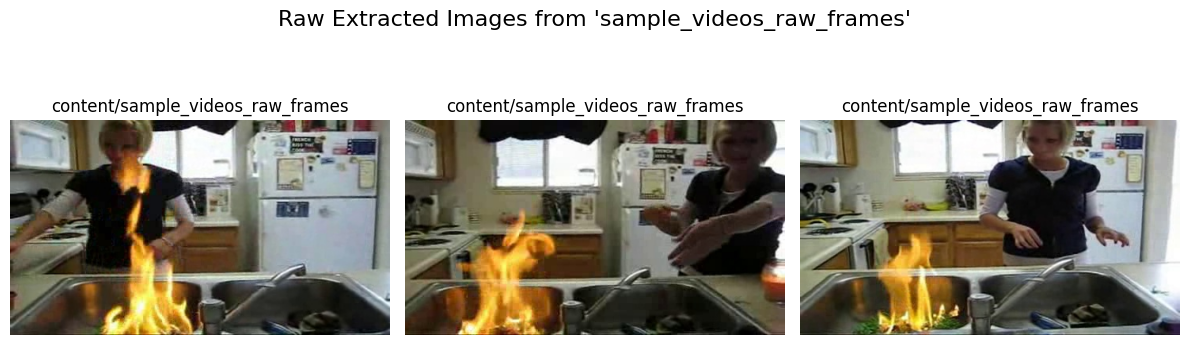

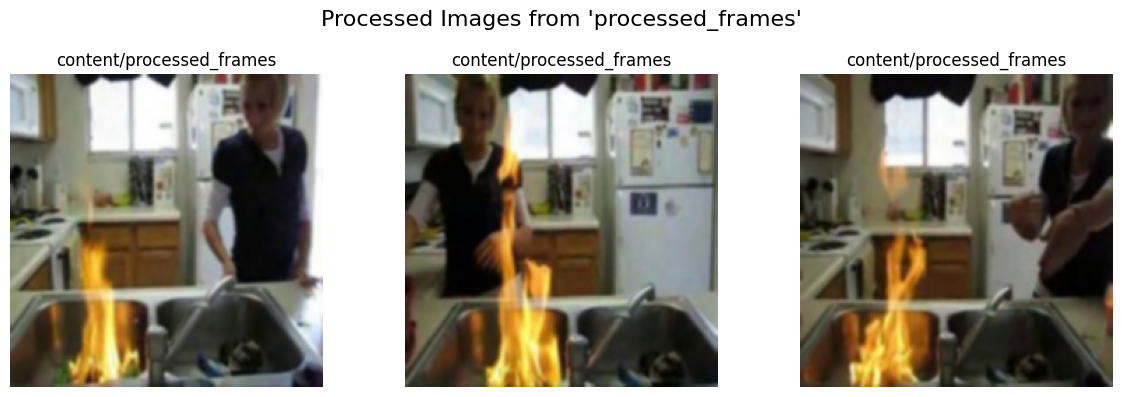


--- Visualizing extracted features for a sample processed image: processed_frame_00414.jpg ---
An error occurred during feature visualization: extract_all_features() missing 1 required positional argument: 'previous_pil_image'

--- Visualizing fire ROI detection for the same sample processed image: processed_frame_00414.jpg ---
🔥 Fire ROI detected and localized in processed_frame_00414.jpg.


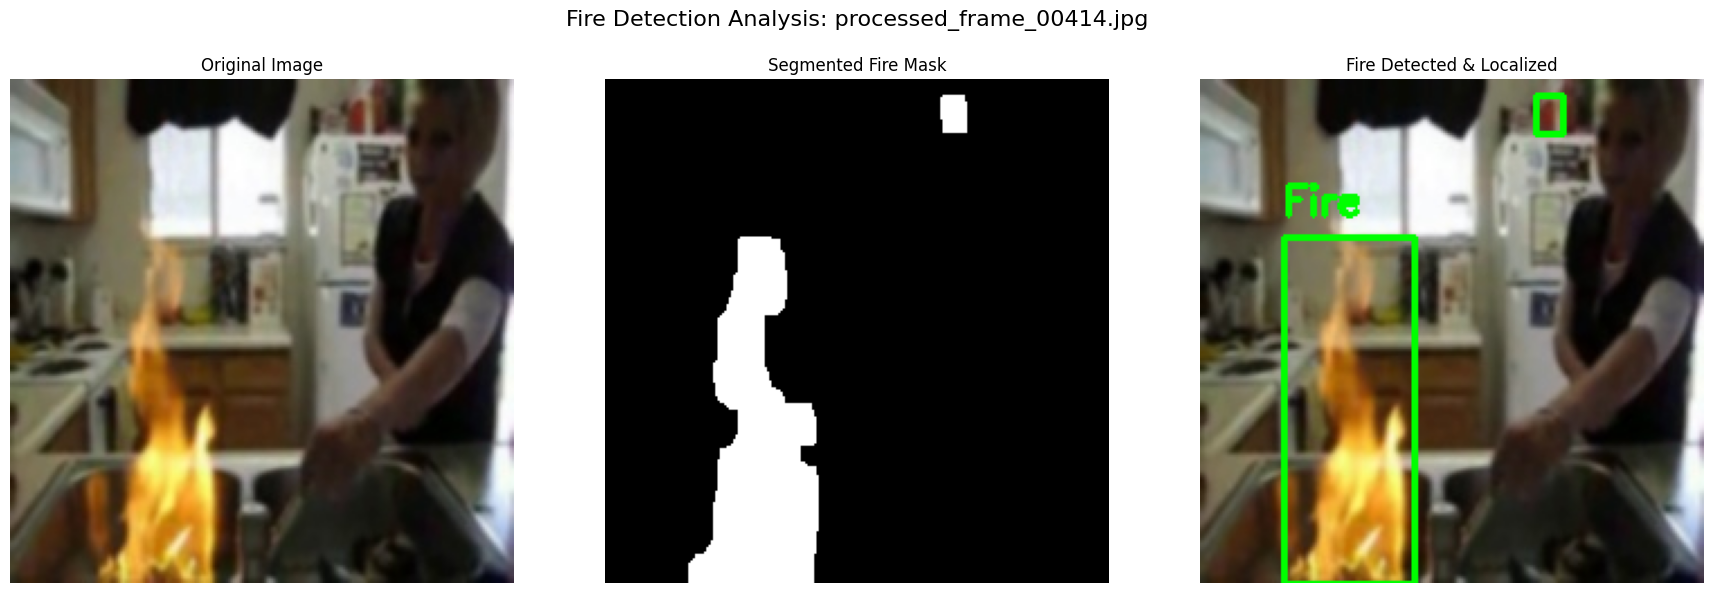


--- Stage 3: Tracking fire in processed frames and creating video: /content/fire_tracked_with_features.avi ---
Starting video creation: /content/fire_tracked_with_features.avi with FPS: 29.97 and frame size: (224, 224)


Tracking fire and creating video:   1%|          | 4/510 [00:00<00:12, 39.77it/s]

Note: First frame, HOF features set to zeros.
Frame 0 (processed_frame_00000.jpg), Features shape: (36,), Fire Detected: True
Frame 1 (processed_frame_00001.jpg), Features shape: (36,), Fire Detected: False
Frame 2 (processed_frame_00002.jpg), Features shape: (36,), Fire Detected: False
Frame 3 (processed_frame_00003.jpg), Features shape: (36,), Fire Detected: False
Frame 4 (processed_frame_00004.jpg), Features shape: (36,), Fire Detected: False


Tracking fire and creating video: 100%|██████████| 510/510 [00:11<00:00, 42.63it/s]


✅ Successfully created video with fire tracking: /content/fire_tracked_with_features.avi

--- Stage 4: Re-extracting frames from tracked video (fire_tracked_with_features.avi) ---
Video: fire_tracked_with_features.avi, FPS: 29.97, Total frames reported: 510


Extracting frames from fire_tracked_with_features.avi: 100%|██████████| 510/510 [00:00<00:00, 1121.38it/s]


Successfully extracted 510 frames to /content/reextracted_tracked_frames/

--- Displaying sample re-extracted frames (if any) ---


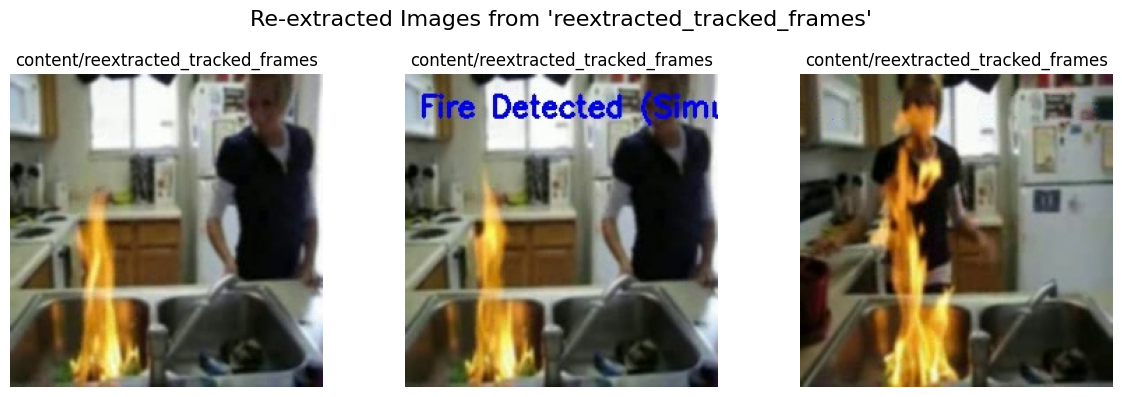


--- Stage 5: Creating final ROI visualization video from re-extracted frames: /content/final_roi_on_reextracted.avi ---
Starting ROI visualization video creation: /content/final_roi_on_reextracted.avi with FPS: 29.97


Creating final ROI video: 100%|██████████| 510/510 [00:01<00:00, 428.14it/s]


✅ Successfully created final ROI visualization video: /content/final_roi_on_reextracted.avi

--- Displaying sample frames from the final ROI video (by re-extracting them again for display) ---
Video: final_roi_on_reextracted.avi, FPS: 29.97, Total frames reported: 510


Extracting frames from final_roi_on_reextracted.avi: 100%|██████████| 510/510 [00:00<00:00, 1025.44it/s]


Successfully extracted 510 frames to /content/temp_final_frames_display/


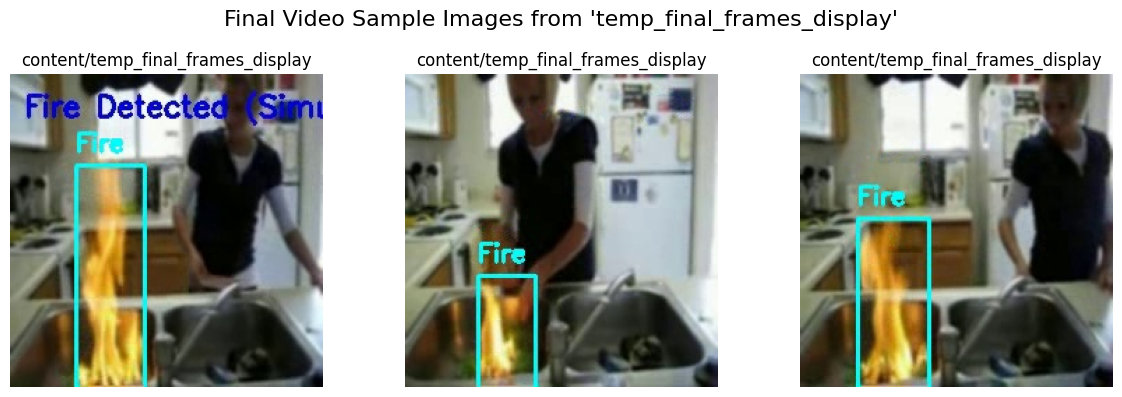


--- Processing complete. ---


In [ ]:
base_content_path = '/content/'
sample_videos_path = os.path.join(base_content_path, 'firesense/fire/pos/posVideo2.871.avi')
raw_frames_output_folder = os.path.join(base_content_path, 'sample_videos_raw_frames/')
processed_frames_folder = os.path.join(base_content_path, 'processed_frames/')

tracked_video_with_features_path = os.path.join(base_content_path, 'fire_tracked_with_features.avi')
reextracted_frames_from_tracked_video_folder = os.path.join(base_content_path, 'reextracted_tracked_frames/')
final_roi_visualization_video_path = os.path.join(base_content_path, 'final_roi_on_reextracted.avi')

# --- Step 1 & 2: Extract and Preprocess Frames (from user's original setup) ---
print("--- Stage 1: Extracting raw frames from source video ---")
# The extract_frames function was modified to return (saved_count, fps)
saved_raw_count, source_video_fps = extract_frames(sample_videos_path, raw_frames_output_folder)

# Use a default FPS if extraction failed to get it or if no frames
effective_fps = source_video_fps if source_video_fps and source_video_fps > 0 and saved_raw_count > 0 else 25.0
print(f"Effective FPS for video creation will be: {effective_fps:.2f}")

if saved_raw_count > 0:
    print(f"\n--- Stage 2: Preprocessing {saved_raw_count} raw frames ---")
    preprocess_all_frames(raw_frames_output_folder, processed_frames_folder) # target_size defaults to (224,224)

    print("\n--- Displaying sample raw and processed frames (if any) ---")
    display_sample_images(raw_frames_output_folder, num_samples=3, title_prefix="Raw Extracted")
    display_sample_images(processed_frames_folder, num_samples=3, title_prefix="Processed")

    # --- Visualizing features for one sample processed image (from user's original setup) ---
    sample_processed_img_paths = glob.glob(os.path.join(processed_frames_folder, '*.jpg'))
    if sample_processed_img_paths:
        image_path_for_feature_viz = sample_processed_img_paths[0]
        print(f"\n--- Visualizing extracted features for a sample processed image: {os.path.basename(image_path_for_feature_viz)} ---")
        try:
            pil_sample_image_for_features = Image.open(image_path_for_feature_viz).convert('RGB')
            final_features = extract_all_features(pil_sample_image_for_features)
            print(f"Shape of the final combined feature vector for sample: {final_features.shape}")
        except FileNotFoundError:
            print(f"Error: Sample processed image {image_path_for_feature_viz} not found for feature visualization.")
        except Exception as e:
            print(f"An error occurred during feature visualization: {e}")

        print(f"\n--- Visualizing fire ROI detection for the same sample processed image: {os.path.basename(image_path_for_feature_viz)} ---")
        detect_and_visualize_fire_roi(image_path_for_feature_viz) # Using the original detailed plot function
    else:
        print(f"No processed images found in {processed_frames_folder} to visualize features or ROI.")


    # --- Step 3: Track fire in processed frames, extract features, and export to video ---
    print(f"\n--- Stage 3: Tracking fire in processed frames and creating video: {tracked_video_with_features_path} ---")
    track_fire_and_extract_features_to_video(processed_frames_folder, tracked_video_with_features_path, effective_fps)

    # --- Step 4: Re-extract frames from the tracked video ---
    print(f"\n--- Stage 4: Re-extracting frames from tracked video ({os.path.basename(tracked_video_with_features_path)}) ---")
    # Ensure the output folder for re-extracted frames exists
    if not os.path.exists(reextracted_frames_from_tracked_video_folder):
        os.makedirs(reextracted_frames_from_tracked_video_folder)

    saved_reextracted_count, fps_from_tracked_video = extract_frames(tracked_video_with_features_path, reextracted_frames_from_tracked_video_folder)

    # Use FPS from the tracked video if available, otherwise stick to original effective_fps
    final_video_fps = fps_from_tracked_video if fps_from_tracked_video and fps_from_tracked_video > 0 and saved_reextracted_count > 0 else effective_fps

    if saved_reextracted_count > 0:
        print("\n--- Displaying sample re-extracted frames (if any) ---")
        display_sample_images(reextracted_frames_from_tracked_video_folder, num_samples=3, title_prefix="Re-extracted")

        # --- Step 5: Detect and visualize ROI on re-extracted frames and save to a new output video ---
        print(f"\n--- Stage 5: Creating final ROI visualization video from re-extracted frames: {final_roi_visualization_video_path} ---")
        create_roi_visualization_video(reextracted_frames_from_tracked_video_folder, final_roi_visualization_video_path, final_video_fps)

        print("\n--- Displaying sample frames from the final ROI video (by re-extracting them again for display) ---")
        temp_final_frames_display_folder = os.path.join(base_content_path, 'temp_final_frames_display/')
        if os.path.exists(final_roi_visualization_video_path):
            extract_frames(final_roi_visualization_video_path, temp_final_frames_display_folder)
            display_sample_images(temp_final_frames_display_folder, num_samples=3, title_prefix="Final Video Sample")
            # Clean up temporary display folder
            # import shutil
            # if os.path.exists(temp_final_frames_display_folder):
            #     shutil.rmtree(temp_final_frames_display_folder)
        else:
            print(f"Final video {final_roi_visualization_video_path} not found for displaying samples.")

    else:
        print(f"No frames were re-extracted from {tracked_video_with_features_path}. Skipping final video creation.")
else:
    print(f"No raw frames were extracted from {sample_videos_path}. Halting subsequent processing stages.")

print("\n--- Processing complete. ---")

<hr>